# Story Image Regeneration Service Testing

This notebook tests the story image generation API endpoints:
1. Generate Story Images - Processes story_parts and creates one image per section
2. Regenerate Segment Image - Regenerates a specific image with user modifications


## Setup and Authentication


In [2]:
import os
import json
import requests
import boto3
from pprint import pprint
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Set AWS environment
os.environ['AWS_PROFILE'] = 'sandbox'
os.environ['AWS_REGION'] = 'us-east-1'

# API Configuration
API_BASE_URL = 'https://6txczj8c6i.execute-api.us-east-1.amazonaws.com/dev'
CLIENT_ID = '1a09blthlvds6lq24afk6k2uuq'
USERNAME = 'admin@example.com'
PASSWORD = 'NewPassword123!'

print("✓ Configuration loaded")


✓ Configuration loaded


In [3]:
# Get authentication token
print("🔐 Getting authentication token...")

cognito_client = boto3.client('cognito-idp', region_name='us-east-1')

auth_response = cognito_client.initiate_auth(
    ClientId=CLIENT_ID,
    AuthFlow='USER_PASSWORD_AUTH',
    AuthParameters={
        'USERNAME': USERNAME,
        'PASSWORD': PASSWORD
    }
)

TOKEN = auth_response['AuthenticationResult']['IdToken']
print(f"✓ Token obtained ({len(TOKEN)} characters)")

# Prepare headers for API calls
headers = {
    'Authorization': TOKEN,
    'Content-Type': 'application/json'
}

# Initialize S3 client for downloading images
s3_client = boto3.client('s3', region_name='us-east-1')

# Helper function to download and display image from S3
def display_image_from_s3(s3_uri, title="Image"):
    """
    Download and display an image from S3
    
    Args:
        s3_uri: S3 URI in format s3://bucket-name/path/to/image.png
        title: Title to display above the image
    """
    try:
        # Parse S3 URI
        if not s3_uri.startswith('s3://'):
            print(f"Invalid S3 URI: {s3_uri}")
            return None
        
        s3_path = s3_uri[5:]  # Remove 's3://'
        bucket_name = s3_path.split('/')[0]
        object_key = '/'.join(s3_path.split('/')[1:])
        
        print(f"Downloading image from: {s3_uri}")
        
        # Download image from S3
        response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
        image_data = response['Body'].read()
        
        # Open image with PIL
        image = Image.open(BytesIO(image_data))
        
        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Image displayed successfully")
        return image
        
    except Exception as e:
        print(f"❌ Error displaying image: {str(e)}")
        return None

print("✓ Helper functions loaded")


🔐 Getting authentication token...
✓ Token obtained (1118 characters)
✓ Helper functions loaded


## Test 1: Generate Story Images

This test accepts a `story_parts` structure and processes it by:
- Combining all segments within each section
- Concatenating segment content into a single combined segment per section
- Collecting all unique speakers from each section into a list
- Using the section_num as the segment_number for image generation
- Generating one image per section

**Note**: You can also load story_parts from a JSON file:
```python
# with open('test2_story_response.json', 'r') as f:
#     data = json.load(f)
#     story_parts = data['result']['story_parts']
```


In [4]:
print("📋 TEST 1: Generate Story Images")
print("─" * 70)

# Example story_parts structure (can be loaded from a previous test or JSON file)
# For this example, we'll use a sample story_parts structure
story_parts = [
      {
        "story_part": "beginning",
        "sections": [
          {
            "section_num": 1,
            "segments": [
              {
                "segment_num": 1,
                "segment_content": "In a cozy mouse hole beneath an old bakery lived Max the Mouse, who spent his days collecting crumbs and dreaming of adventure.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 2,
                "segment_content": "One quiet afternoon, Max explored the dusty cellar and noticed a strange golden glow coming from behind some wooden crates.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 3,
                "segment_content": "What could that be? It's so sparkly!",
                "speaker": "Max the Mouse"
              }
            ]
          },
          {
            "section_num": 2,
            "segments": [
              {
                "segment_num": 4,
                "segment_content": "Max pushed the crates aside and discovered a magnificent golden cheese wheel that sparkled with magical light! As he reached out his tiny paw, the cheese glowed even brighter.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 5,
                "segment_content": "Suddenly, a tiny fairy with wings made of cheese appeared, floating gracefully in the air with a warm smile.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 6,
                "segment_content": "Hello, little mouse! I am Glimmer, the Cheese Fairy. You have found the legendary Wishing Cheese! Because you have a pure heart, you may make three wishes.",
                "speaker": "Glimmer the Cheese Fairy"
              },
              {
                "segment_num": 7,
                "segment_content": "Three wishes? I can't believe it!",
                "speaker": "Max the Mouse"
              }
            ]
          }
        ]
      },
      {
        "story_part": "middle",
        "sections": [
          {
            "section_num": 3,
            "segments": [
              {
                "segment_num": 8,
                "segment_content": "Max thought about his friends who often went to bed hungry. His whiskers twitched with excitement as he made his first wish.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 9,
                "segment_content": "I wish for a grand feast to share with all my mouse friends!",
                "speaker": "Max the Mouse"
              },
              {
                "segment_num": 10,
                "segment_content": "The cheese glowed bright as sunshine, and POOF! A magnificent spread of breads, fruits, berries, nuts, and delicious cheeses appeared before Max's amazed eyes!",
                "speaker": "Narrator"
              },
              {
                "segment_num": 11,
                "segment_content": "Soon, all of Max's mouse friends arrived and they celebrated together, dancing and feasting like never before!",
                "speaker": "Narrator"
              }
            ]
          },
          {
            "section_num": 4,
            "segments": [
              {
                "segment_num": 12,
                "segment_content": "After the wonderful party, Max thought carefully about his second wish. He wanted to help his friends even more.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 13,
                "segment_content": "I wish for a safe home where all the mice can live without fear of cats or traps!",
                "speaker": "Max the Mouse"
              },
              {
                "segment_num": 14,
                "segment_content": "The magical cheese sparkled and spun! A hidden doorway opened in the wall, revealing a beautiful mouse village with tiny houses, flower gardens, and winding paths.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 15,
                "segment_content": "You have one wish remaining, Max. Choose wisely, for the magic is almost used up.",
                "speaker": "Glimmer the Cheese Fairy"
              }
            ]
          }
        ]
      },
      {
        "story_part": "end",
        "sections": [
          {
            "section_num": 5,
            "segments": [
              {
                "segment_num": 16,
                "segment_content": "Max looked around at his happy friends playing in their new safe home. He realized he already had everything he could ever want.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 17,
                "segment_content": "Then Max noticed Glimmer sitting on the cheese, looking a bit sad. He understood that she was trapped, bound to the magical cheese forever.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 18,
                "segment_content": "Glimmer, for my final wish, I wish that you could be free from the cheese and have your own life of adventure!",
                "speaker": "Max the Mouse"
              },
              {
                "segment_num": 19,
                "segment_content": "Max! You would use your last wish for me?",
                "speaker": "Glimmer the Cheese Fairy"
              }
            ]
          },
          {
            "section_num": 6,
            "segments": [
              {
                "segment_num": 20,
                "segment_content": "The magical cheese glowed one final time with a brilliant rainbow light! It transformed into regular, delicious cheese, and Glimmer grew into a real fairy, no longer bound by magic.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 21,
                "segment_content": "Thank you, Max! Your selfless heart has given me the greatest gift. I will visit you often, my dear friend!",
                "speaker": "Glimmer the Cheese Fairy"
              },
              {
                "segment_num": 22,
                "segment_content": "Max and his mouse community lived happily ever after in their cozy village. They kept a piece of the special cheese as a reminder that the best wishes are the ones we make for others.",
                "speaker": "Narrator"
              },
              {
                "segment_num": 23,
                "segment_content": "And true to her word, Glimmer visited often, bringing stories of her adventures and filling the mouse village with laughter and joy.",
                "speaker": "Narrator"
              }
            ]
          }
        ]
      }
    ]

# Process story_parts: combine all segments in each section
story_segments = []
for story_part in story_parts:
    for section in story_part['sections']:
        # Concatenate all segment content in this section
        combined_content = " ".join([seg['segment_content'] for seg in section['segments']])
        
        # Collect all unique speakers from this section (preserving order)
        speakers = []
        seen = set()
        for seg in section['segments']:
            if seg['speaker'] not in seen:
                speakers.append(seg['speaker'])
                seen.add(seg['speaker'])
        
        # Create a combined segment with section_num as the segment_number
        story_segments.append({
            "story_segment_number": section['section_num'],
            "story_segment_content": combined_content,
            "story_segment_speakers": speakers
        })

print(f"Processed {len(story_segments)} sections from story_parts")
print("\nCombined story segments:")
pprint(story_segments)

📋 TEST 1: Generate Story Images
──────────────────────────────────────────────────────────────────────
Processed 6 sections from story_parts

Combined story segments:
[{'story_segment_content': 'In a cozy mouse hole beneath an old bakery lived '
                           'Max the Mouse, who spent his days collecting '
                           'crumbs and dreaming of adventure. One quiet '
                           'afternoon, Max explored the dusty cellar and '
                           'noticed a strange golden glow coming from behind '
                           "some wooden crates. What could that be? It's so "
                           'sparkly!',
  'story_segment_number': 1,
  'story_segment_speakers': ['Narrator', 'Max the Mouse']},
 {'story_segment_content': 'Max pushed the crates aside and discovered a '
                           'magnificent golden cheese wheel that sparkled with '
                           'magical light! As he reached out his tiny paw, the '
        

In [7]:
generate_payload = {
    "story_segments": story_segments,
    "art_style": "whimsical watercolor illustration",
    "number_of_panels": len(story_segments),
    "job_id": "test-job-image-001"
}

print("\nRequest payload:")
pprint(generate_payload)

print("\nSending request...")
print("⏳ Note: Image generation may take 30-60 seconds per image...")
response = requests.post(
    f"{API_BASE_URL}/generate-story-image",
    headers=headers,
    json=generate_payload
)

print(f"\nResponse Status: {response.status_code}")
print("\nResponse Body:")
image_response = response.json()
pprint(image_response)

if response.status_code == 200:
    print("\n✅ PASS - Story image generation successful")
    
    # Extract the first image S3 URL for Test 2
    if 'result' in image_response and 'story_segments' in image_response['result']:
        if len(image_response['result']['story_segments']) > 0:
            original_image_s3_uri = image_response['result']['story_segments'][0].get('image_s3_url')
            
            if original_image_s3_uri:
                print("\n📝 Image S3 URI extracted for regeneration test:")
                print(f"   {original_image_s3_uri}")
            else:
                print("\n⚠️  WARNING - Could not extract image S3 URI, Test 2 will be skipped")
                original_image_s3_uri = None
        else:
            print("\n⚠️  WARNING - No story segments in response, Test 2 will be skipped")
            original_image_s3_uri = None
    else:
        print("\n⚠️  WARNING - Unexpected response format, Test 2 will be skipped")
        original_image_s3_uri = None
    
    # Export response to JSON file
    output_file = "test1_image_generation_response.json"
    with open(output_file, 'w') as f:
        json.dump(image_response, f, indent=2)
    print(f"💾 Response exported to: {output_file}")
else:
    print(f"\n❌ FAIL - Expected 200 but got {response.status_code}")
    original_image_s3_uri = None
    raise Exception("Test 1 failed")



Request payload:
{'art_style': 'whimsical watercolor illustration',
 'job_id': 'test-job-image-001',
 'number_of_panels': 6,
 'story_segments': [{'story_segment_content': 'In a cozy mouse hole beneath an '
                                              'old bakery lived Max the Mouse, '
                                              'who spent his days collecting '
                                              'crumbs and dreaming of '
                                              'adventure. One quiet afternoon, '
                                              'Max explored the dusty cellar '
                                              'and noticed a strange golden '
                                              'glow coming from behind some '
                                              'wooden crates. What could that '
                                              "be? It's so sparkly!",
                     'story_segment_number': 1,
                     'story_segment_speakers': 

🖼️  Displaying generated images...
──────────────────────────────────────────────────────────────────────

📷 Image 1 - Section 1
   Speakers: Unknown
   Content: In a cozy mouse hole beneath an old bakery lived Max the Mouse, who spent his days collecting crumbs...



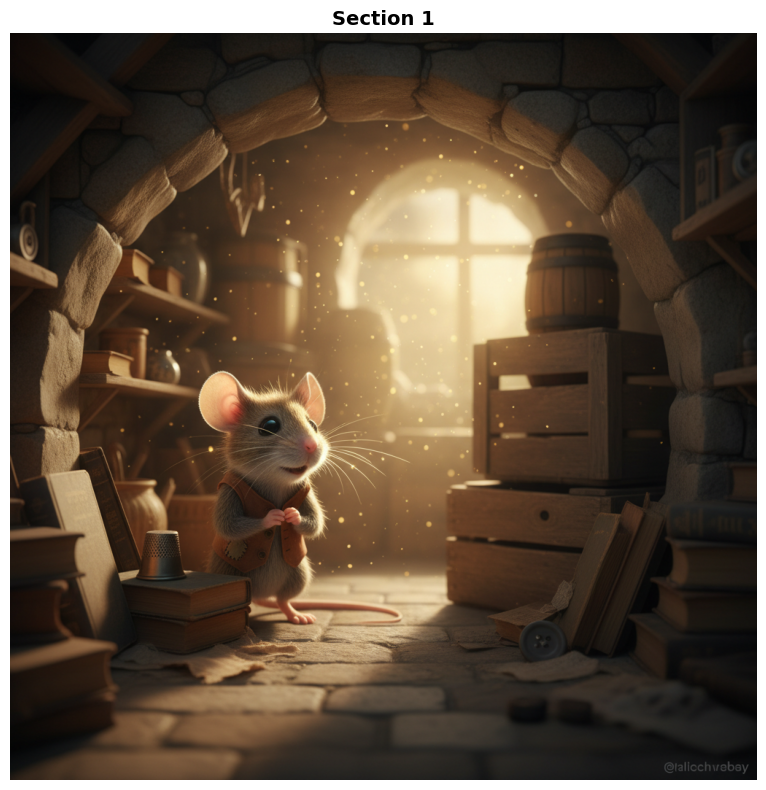

✓ Image displayed successfully


📷 Image 2 - Section 2
   Speakers: Unknown
   Content: Max pushed the crates aside and discovered a magnificent golden cheese wheel that sparkled with magi...



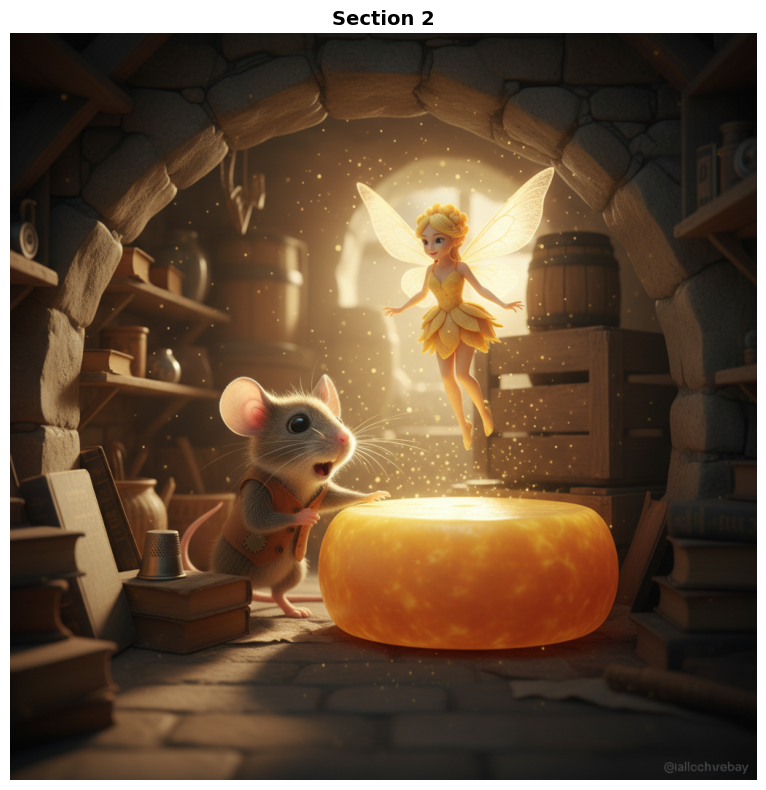

✓ Image displayed successfully


📷 Image 3 - Section 3
   Speakers: Unknown
   Content: Max thought about his friends who often went to bed hungry. His whiskers twitched with excitement as...



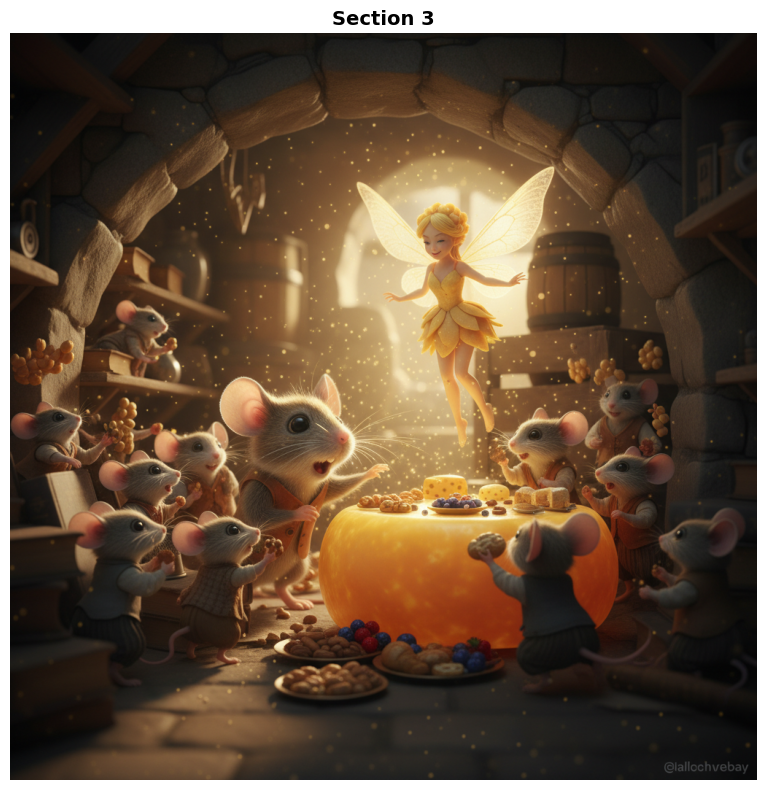

✓ Image displayed successfully


📷 Image 4 - Section 4
   Speakers: Unknown
   Content: After the wonderful party, Max thought carefully about his second wish. He wanted to help his friend...



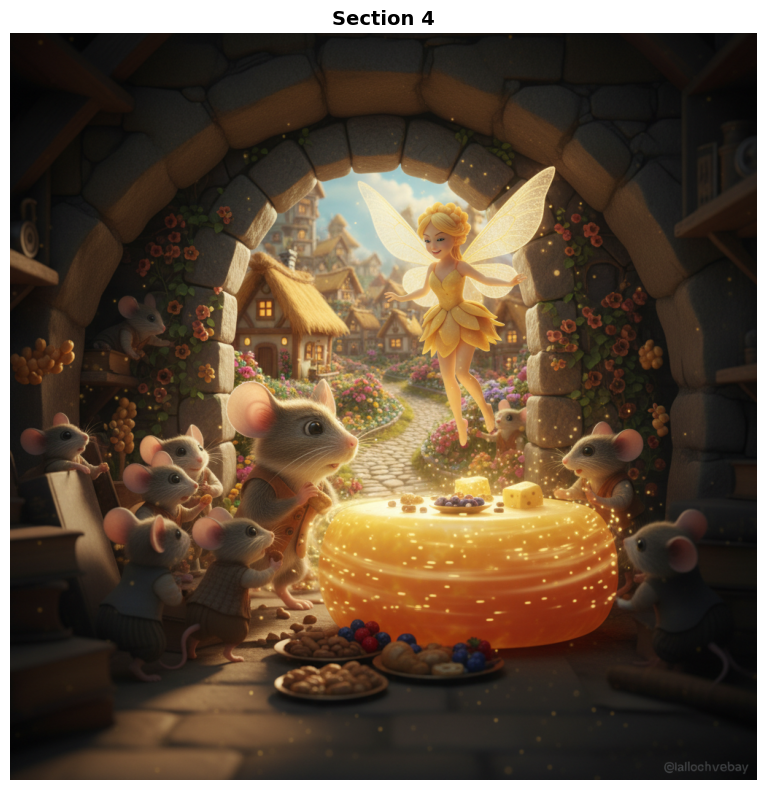

✓ Image displayed successfully


📷 Image 5 - Section 5
   Speakers: Unknown
   Content: Max looked around at his happy friends playing in their new safe home. He realized he already had ev...



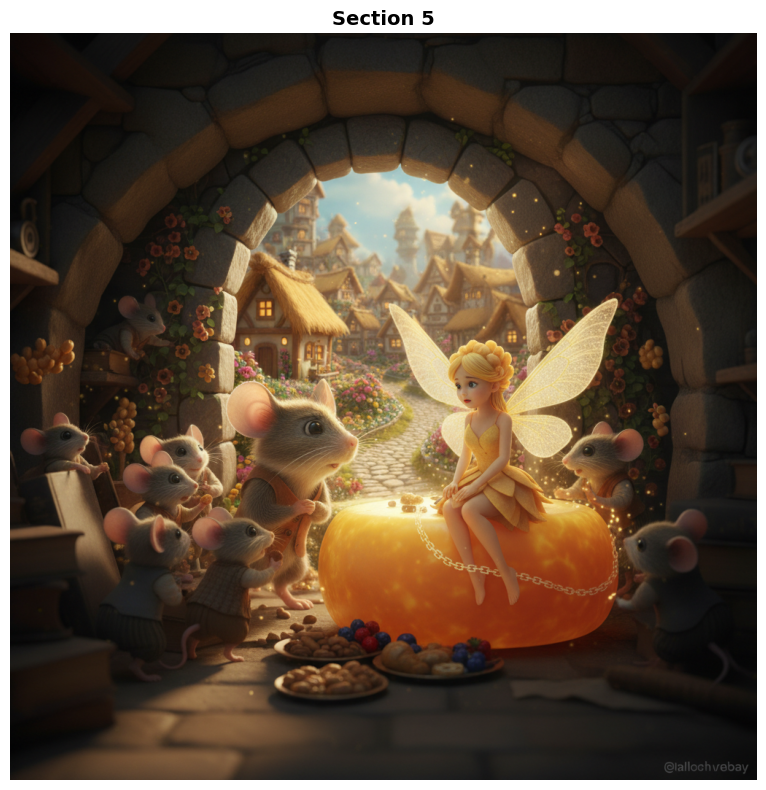

✓ Image displayed successfully


📷 Image 6 - Section 6
   Speakers: Unknown
   Content: The magical cheese glowed one final time with a brilliant rainbow light! It transformed into regular...



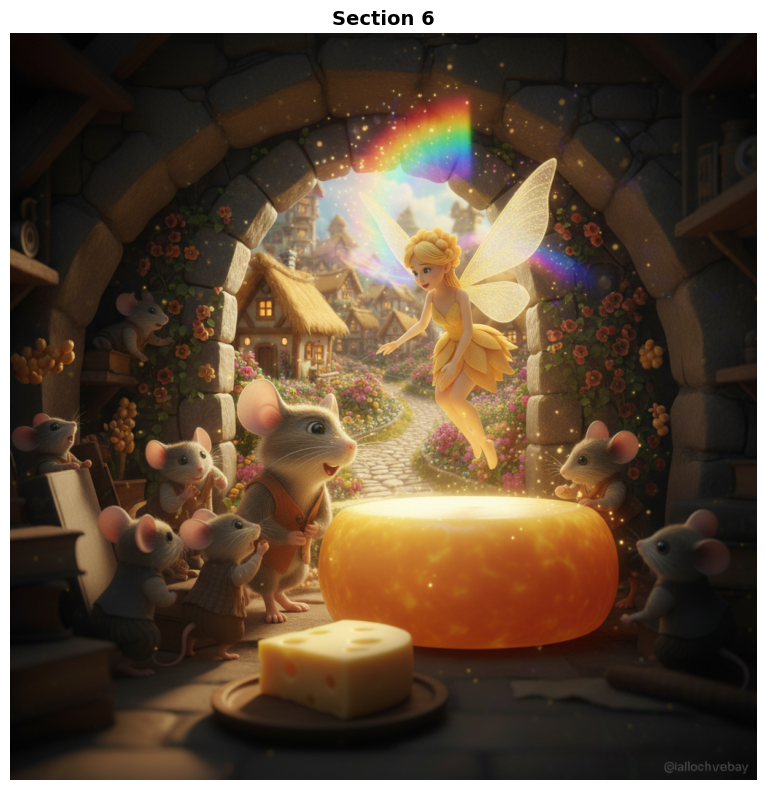

✓ Image displayed successfully

✓ Displayed 6 images successfully


In [8]:
if response.status_code == 200 and 'result' in image_response and 'story_segments' in image_response['result']:
    print("🖼️  Displaying generated images...")
    print("─" * 70)
    
    generated_images = []
    for idx, segment in enumerate(image_response['result']['story_segments'], 1):
        image_url = segment.get('image_s3_url')
        if image_url:
            print(f"\n📷 Image {idx} - Section {segment.get('story_segment_number', idx)}")
            print(f"   Speakers: {', '.join(segment.get('story_segment_speakers', ['Unknown']))}")
            print(f"   Content: {segment.get('story_segment_content', '')[:100]}...")
            print()
            img = display_image_from_s3(image_url, f"Section {segment.get('story_segment_number', idx)}")
            if img:
                generated_images.append(img)
            print()
    
    print(f"✓ Displayed {len(generated_images)} images successfully")
else:
    print("⚠️  No images to display from Test 1")

## Test 2: Regenerate Segment Image

Regenerate the first image with modifications based on user request.


### Display Images Comparison (Original vs Regenerated)


In [9]:
if original_image_s3_uri:
    print("📋 TEST 2: Regenerate Segment Image")
    print("─" * 70)
    
    regenerate_payload = {
        "user_request": "make the scene brighter and add more colorful flowers in the background",
        "original_segment_image_s3_uri": original_image_s3_uri,
        "job_id": "test-job-image-regen-002"
    }
    
    print("\nRequest payload:")
    pprint(regenerate_payload)
    
    print("\nSending request to regenerate image...")
    print("⏳ Note: Image regeneration may take 30-60 seconds...")
    response = requests.post(
        f"{API_BASE_URL}/regenerate-segment-image",
        headers=headers,
        json=regenerate_payload
    )
    
    print(f"\nResponse Status: {response.status_code}")
    print("\nResponse Body:")
    regenerate_response = response.json()
    pprint(regenerate_response)
    
    if response.status_code == 200:
        print("\n✅ PASS - Image regeneration successful")
        
        # Extract new image URL
        if 'result' in regenerate_response and 'new_story_segment_image' in regenerate_response['result']:
            new_image_s3_uri = regenerate_response['result']['new_story_segment_image']
            
            print("\n📊 Comparison:")
            print(f"  Original Image: {original_image_s3_uri}")
            print(f"  Regenerated Image: {new_image_s3_uri}")
        
        # Export response to JSON file
        output_file = "test2_image_regeneration_response.json"
        with open(output_file, 'w') as f:
            json.dump(regenerate_response, f, indent=2)
        print(f"💾 Response exported to: {output_file}")
    else:
        print(f"\n❌ FAIL - Expected 200 but got {response.status_code}")
        raise Exception("Test 2 failed")
else:
    print("⚠️  SKIP - Test 2 skipped: No image S3 URI from Test 1")


📋 TEST 2: Regenerate Segment Image
──────────────────────────────────────────────────────────────────────

Request payload:
{'job_id': 'test-job-image-regen-002',
 'original_segment_image_s3_uri': 's3://aws-hackathon-2025-story-images-dev/users/3488e408-5061-702b-2c5d-83be4c54f069/jobs/test-job-image-001/segment_1.png',
 'user_request': 'make the scene brighter and add more colorful flowers in the '
                 'background'}

Sending request to regenerate image...
⏳ Note: Image regeneration may take 30-60 seconds...

Response Status: 200

Response Body:
{'authenticated_user': {'email': 'admin@example.com',
                        'sub': '3488e408-5061-702b-2c5d-83be4c54f069',
                        'username': '3488e408-5061-702b-2c5d-83be4c54f069'},
 'request_id': '203b390e-a927-4a1a-91f9-3893b2889e76',
 'result': {'metadata': {'created_timestamp': '2025-10-03T20:00:22.487987+00:00',
                         'job_id': 'test-job-image-regen-002',
                         'origina

🖼️  Displaying image comparison...
──────────────────────────────────────────────────────────────────────

📷 Original Image:
✓ Downloaded from: s3://aws-hackathon-2025-story-images-dev/users/3488e408-5061-702b-2c5d-83be4c54f069/jobs/test-job-image-001/segment_1.png

📷 Regenerated Image:
✓ Downloaded from: s3://aws-hackathon-2025-story-images-dev/users/3488e408-5061-702b-2c5d-83be4c54f069/jobs/test-job-image-regen-002/segment_1_regenerated_20251003200022.png

📊 Side-by-side comparison:


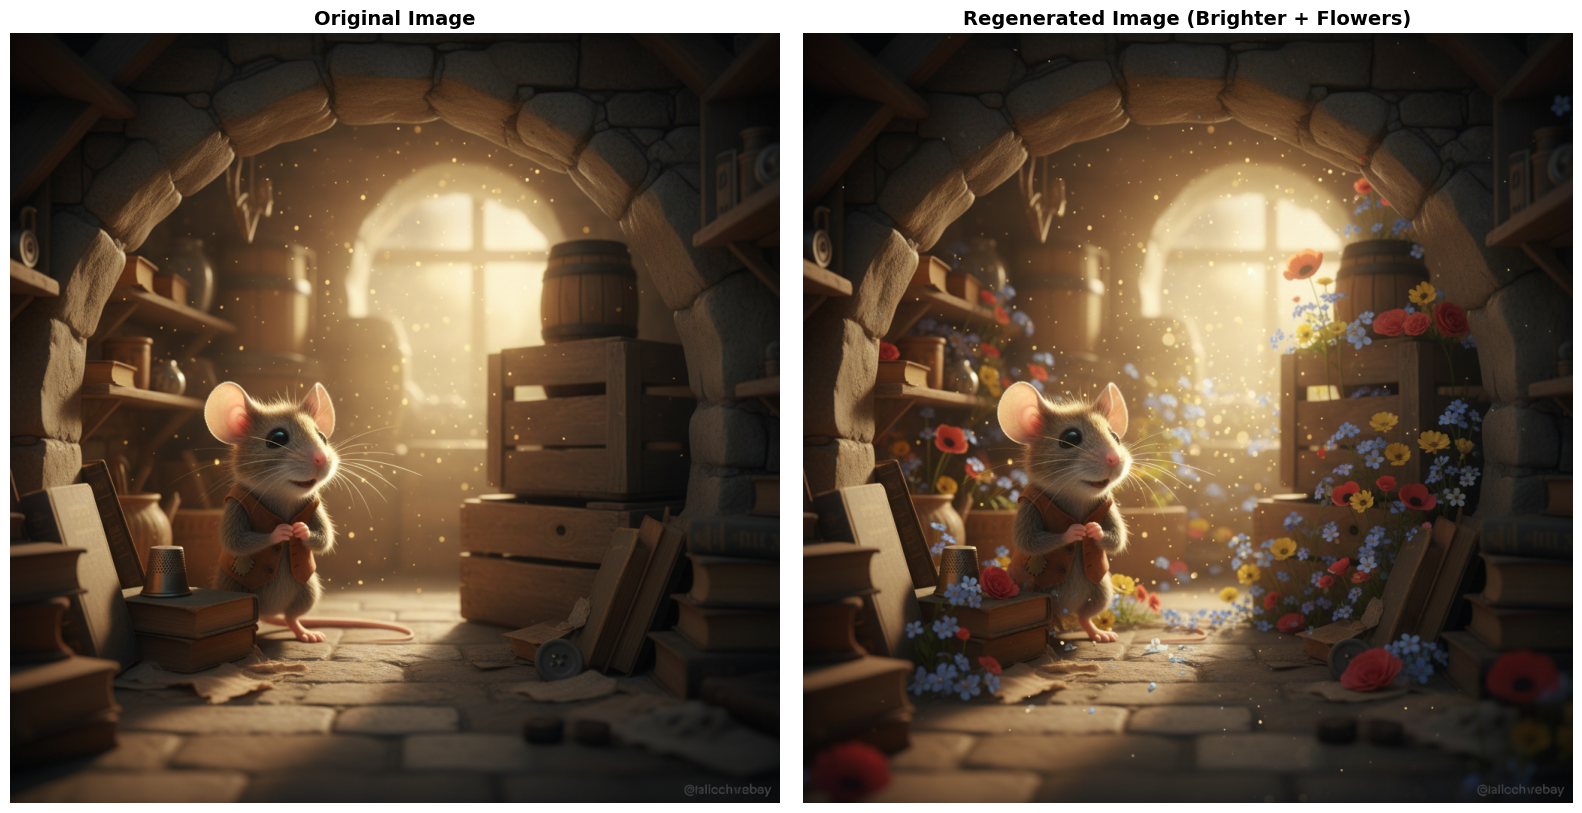

✓ Comparison displayed successfully


In [10]:
if original_image_s3_uri and 'regenerate_response' in locals() and regenerate_response.get('result'):
    print("🖼️  Displaying image comparison...")
    print("─" * 70)
    
    # Get the regenerated image URI
    new_image_s3_uri = regenerate_response['result'].get('new_story_segment_image')
    
    if new_image_s3_uri:
        # Download both images
        print("\n📷 Original Image:")
        try:
            s3_path = original_image_s3_uri[5:]
            bucket_name = s3_path.split('/')[0]
            object_key = '/'.join(s3_path.split('/')[1:])
            response_obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
            original_img = Image.open(BytesIO(response_obj['Body'].read()))
            print(f"✓ Downloaded from: {original_image_s3_uri}")
        except Exception as e:
            print(f"❌ Error downloading original image: {e}")
            original_img = None
        
        print("\n📷 Regenerated Image:")
        try:
            s3_path = new_image_s3_uri[5:]
            bucket_name = s3_path.split('/')[0]
            object_key = '/'.join(s3_path.split('/')[1:])
            response_obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
            regenerated_img = Image.open(BytesIO(response_obj['Body'].read()))
            print(f"✓ Downloaded from: {new_image_s3_uri}")
        except Exception as e:
            print(f"❌ Error downloading regenerated image: {e}")
            regenerated_img = None
        
        # Display side by side
        if original_img and regenerated_img:
            print("\n📊 Side-by-side comparison:")
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            
            axes[0].imshow(original_img)
            axes[0].axis('off')
            axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
            
            axes[1].imshow(regenerated_img)
            axes[1].axis('off')
            axes[1].set_title('Regenerated Image (Brighter + Flowers)', fontsize=14, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            print("✓ Comparison displayed successfully")
        elif original_img:
            display_image_from_s3(original_image_s3_uri, "Original Image")
        elif regenerated_img:
            display_image_from_s3(new_image_s3_uri, "Regenerated Image")
    else:
        print("⚠️  Could not find regenerated image URI")
else:
    print("⚠️  No images to compare from Test 2")
